In [ ]:
!pip install --user --quiet tensorflow gensim yfinance

# 1. Sentiment analysis

In [ ]:
from IPython.display import clear_output
! pip install --quiet kaggle
! mkdir ~/.kaggle
! echo "{\"username\":\"tupoylogin\",\"key\":\"290a55772726b66c496aa74ea7bc8a1f\"}" > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tejasurya/huge-stock-market-crash-2022
! kaggle datasets download -d miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests
! kaggle datasets download -d timospinde/mbic-a-media-bias-annotation-dataset
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
clear_output()

In [ ]:
! unzip huge-stock-market-crash-2022.zip -d train
! unzip massive-stock-news-analysis-db-for-nlpbacktests.zip -d train
! unzip mbic-a-media-bias-annotation-dataset.zip -d train
clear_output()

In [ ]:
clear_output()

In [ ]:
import tensorflow as tf
import numpy as np
import gensim.downloader as api
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
from IPython.display import clear_output
twitter_vectors = api.load('glove-twitter-50') # наперед навчена модель GloVe на твітвах (3 млрд твітів, 2 млн слів)
# головна особливість W2V моделей - вектори слів, що схожі сематично є неортогональними (кут нахилу між векторами < pi/2))
# GloVe - Global Vectors - набір векторів W2V моделі
clear_output()

In [ ]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
wnl = WordNetLemmatizer()

def filter_out_non_text(text: str) -> str:
  filtered_text = re.sub(r'[^\w\s]', '', text) # прибрати пунктуацію
  filtered_text = repr(filtered_text.encode('utf-8'))[2:-1] # black magic (емодзі до строки) (у utf-8 емодзі має вигляд \x(від трьох цифр в 16-розрядній арифметиці))
  filtered_text = filtered_text.replace('\\n',' ')
  filtered_text = re.sub(r"won\'t", "will not", filtered_text)
  filtered_text = re.sub(r"can\'t", "can not", filtered_text)
  filtered_text = re.sub(r"n\'t", " not", filtered_text)
  filtered_text = re.sub(r"\'re", " are", filtered_text)
  filtered_text = re.sub(r"(he|He)\'s", "he is", filtered_text)
  filtered_text = re.sub(r"(she|She)\'s", "she is", filtered_text)
  filtered_text = re.sub(r"(it|It)\'s", "it is", filtered_text)
  filtered_text = re.sub(r"\'d", " would", filtered_text)
  filtered_text = re.sub(r"\'ll", " will", filtered_text)
  filtered_text = re.sub(r"\'t", " not", filtered_text)
  filtered_text = re.sub(r"[#@$]", "", filtered_text)
  filtered_text = re.sub(r"(\'ve|has)", " have", filtered_text)
  filtered_text = re.sub(r"\'m", " am", filtered_text)
  filtered_text = re.sub(r"\\x[a-f0-9]*", "", filtered_text) # прибрати емодзі
  filtered_text = filtered_text.split(' ')
  filtered_text = ' '.join([
      wnl.lemmatize(word.lower()) for word in filtered_text if word.isalpha() # lemmatizer. приводить слова до називного відмінку (іменники + прикметники) або інфінітиву (дієслова) в однині
      ])
  return filtered_text

In [ ]:
import pandas as pd

In [ ]:
text = pd.read_csv('train/stock_market_crash_2022.csv')[['text', 'text_sentiment']]

In [ ]:
text

,text,text_sentiment
0,When will the #NYSE #stockmarketcrash happen?,Neutral
1,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative
2,The stock market needs to crash hard to make i...,Negative
3,"Those who are ""Buying on DIP"" will very soon b...",Neutral
4,@rdrhwke I wish our so-called President were t...,Positive
...,...,...
33941,Hey #btc maxis!!\n\nDo you know what a Fibonac...,Neutral
33942,@cryptolifemama #XRP and #HBAR will be resista...,Neutral
33943,$SPY $SPX\nNotes From a #Market #Degenerate: \...,Positive
33944,@chip82many @GarethSoloway Depends if you thin...,Positive


In [ ]:
filtered_text = text['text'].map(filter_out_non_text)

In [ ]:
filtered_list = list(map(lambda sentence: sentence.split(' '), filtered_text.values.tolist()))

In [ ]:
all_vocab = set(sum(filtered_list, []))

In [ ]:
dataset = text[['text_sentiment']]
dataset['texts'] = filtered_text

dataset.head()

,text_sentiment,texts
0,Neutral,when will the nyse stockmarketcrash happen
1,Negative,aaj ka gyan if a company isnt a quality compan...
2,Negative,the stock market need to crash hard to make it...
3,Neutral,those who are buying on dip will very soon bec...
4,Positive,rdrhwke i wish our socalled president were tra...


In [ ]:
all_vocab = all_vocab & set(twitter_vectors.index_to_key[:]) # створення словнику

In [ ]:
def construct_vocabulary():
  res = []
  for word in all_vocab:
    if word != '':
        res.append(twitter_vectors[word])
  return np.vstack(res)

In [ ]:
vocabulary = construct_vocabulary()

In [ ]:
all_vocab = [x for x in all_vocab if x!='']

In [ ]:
vocabulary = np.vstack((np.zeros((2, 50)), vocabulary))

In [ ]:
class SentimentModel(tf.keras.Model):
  def __init__(self,
               max_token: int,
               kernel_size: int,
               filters: int):
    super().__init__(self)
    self.vectorizer=tf.keras.layers.TextVectorization(output_sequence_length=max_token, vocabulary=all_vocab)
    self.embeddings=tf.keras.layers.Embedding(len(all_vocab) + 2, 50, weights=tf.constant([vocabulary]))
    self.conv_1=tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
    self.average_1 = tf.keras.layers.AveragePooling1D(2)
    self.conv_2=tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
    self.average_2 = tf.keras.layers.AveragePooling1D(2)
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(64, activation='relu')
    self.output_layer = tf.keras.layers.Dense(3, activation='softmax')

  def call(self, input_):
    o=self.vectorizer(input_)
    o=self.embeddings(o)
    o=self.conv_1(o)
    o=self.average_1(o)
    o=self.conv_2(o)
    o=self.average_2(o)
    o=self.flatten(o)
    o=self.dense(o)
    o=self.output_layer(o)
    return o

In [ ]:
dataset

,text_sentiment,texts
0,Neutral,when will the nyse stockmarketcrash happen
1,Negative,aaj ka gyan if a company isnt a quality compan...
2,Negative,the stock market need to crash hard to make it...
3,Neutral,those who are buying on dip will very soon bec...
4,Positive,rdrhwke i wish our socalled president were tra...
...,...,...
33941,Neutral,hey btc maxi do you know what a fibonacci exte...
33942,Neutral,cryptolifemama xrp and hbar will be resistant ...
33943,Positive,spy spx note from a market degenerate some chi...
33944,Positive,garethsoloway depends if you think feel were s...


In [ ]:
semantic_model = SentimentModel(max_token=30, kernel_size=3, filters=64)

In [ ]:
semantic_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
y = pd.get_dummies(dataset['text_sentiment'])

In [ ]:
semantic_model.fit(x=dataset[['texts']].values, y=y.values, validation_split=0.4, epochs=50, batch_size=64, verbose=0)

In [ ]:
import gc
del text, dataset, vocabulary, all_vocab
gc.collect()

1543

# 2. Time series prep

In [ ]:
columns = ['Open', 'Close', 'High', 'Low', 'Volume']

In [ ]:
import talib
import yfinance
import gzip
import typing as tp
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import os
tickers = ['AAPL', 'TSLA', 'MSFT', 'AMZN', 'GOOG', 'V', 'NVDA']

def read_tickers(tickers):
  """
  Read and process stock prices fro given list of tickers
  """
  df = dict()
  for ticker_name in tickers:
    ticker = yfinance.Ticker(ticker_name)
    history_prices = ticker.history('1d', start='2015-01-01', end='2020-07-01')[columns]
    df[ticker_name] = history_prices
  return df

def plot_tickers(tickers_dataset: pd.DataFrame, name: str = 'Stock Prices'):
  """
  Plot tickers from tickers dataset
  """
  number_of_plots = len(tickers_dataset.columns)
  fig, ax = plt.subplots(number_of_plots, figsize=(15, 10))
  fig.suptitle(name)
  for idx, ticker in enumerate(tickers_dataset.columns):
    if number_of_plots > 1:
      axis = ax[idx]
    else:
      axis = ax
    axis.plot(tickers_dataset.index.values.ravel(), tickers_dataset[ticker].values.ravel())
    axis.set(ylabel=ticker)
  plt.show()

def shift_data(tickers_dataset, y_col, days_shift):
  """
  Add to data some lags for given column
  """
  new_dataset = tickers_dataset.copy()
  for lag in range(1, days_shift + 1):
    new_dataset[f'{y_col}_-{lag}'] = new_dataset[y_col].shift(lag)

  return new_dataset

In [ ]:
dict_nasdaq = read_tickers(tickers)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

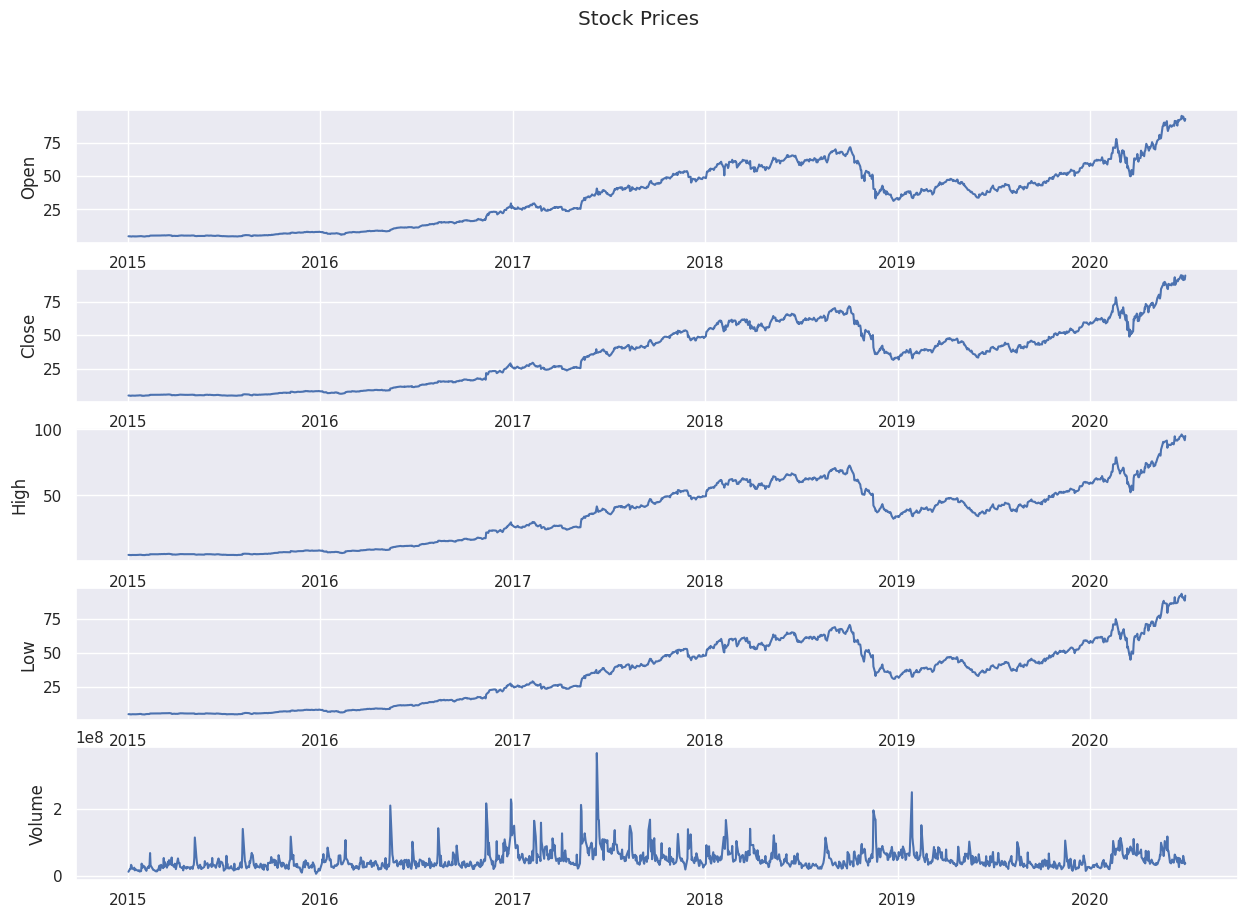

In [ ]:
plot_tickers(dict_nasdaq['NVDA'])

In [ ]:
def compute_return_for_k_days(df: pd.DataFrame, k: int = 0):
  column_name = 'Return' + (f'{k}_days' if k else '')
  df[column_name] = df['Close'] - df['Open'].shift(-k)
def compute_future_return_for_k_days(df: pd.DataFrame, k: int = 0):
  column_name = 'Future_Return' + (f'{k}_days' if k else '')
  df[column_name] = df['Close'].shift(-k) - df['Open']

1. Balance of Power:  
$ BOP = \frac{Close_{i} - Open_{i}}{High_{i} - Low{i}} $
2. Commodity Channel Index:  
$ CCI = \frac{TypicalPrice-MA}{0.15 \times MeanDeviation}$
3. Money Flow Index:  
$ MFI = 100 - \frac{100}{ 1 + MoneyFlowRatio}$
4. Stochastic RSI:  
$ StochRSI = \frac{RSI_{i} - MIN[RSI]_{i}}{MAX[RSI]_{i} - MIN[RSI]_{i}}$  ,  
$RSI$ - [Relative Strength index](https://en.wikipedia.org/wiki/Relative_strength_index)


In [ ]:
def compute_stoch(x: pd.DataFrame,
                  fastk_period: int = 14,
                  slowk_period: int = 3,
                  slowk_matype: int = 0,
                  slowd_period: int = 3,
                  slowd_matype: int = 0):
  slowk, slowd = talib.STOCH(x['High'].ffill(), x['Low'].ffill(), x['Close'].ffill(),
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)
  x['slowd'] = slowd
  x['slowk'] = slowk

def compute_bop(x: pd.DataFrame):
  x['BOP'] = talib.BOP(x['Open'],
                       x['High'],
                       x['Low'],
                       x['Close'])

def compute_cci(x: pd.DataFrame):
  x['CCI'] = talib.CCI(x['High'],
                       x['Low'],
                       x['Close'])

def compute_mfi(x: pd.DataFrame, timeperiod: int = 14):
  x['MFI'] = talib.MFI(x['High'],
                       x['Low'],
                       x['Close'],
                       x['Volume'],
                       timeperiod=timeperiod)

def compute_wma(x: pd.DataFrame, column: str):
  x['WMA_'+column] = talib.WMA(x[column].fillna(method='pad'))

In [ ]:
import numpy as np

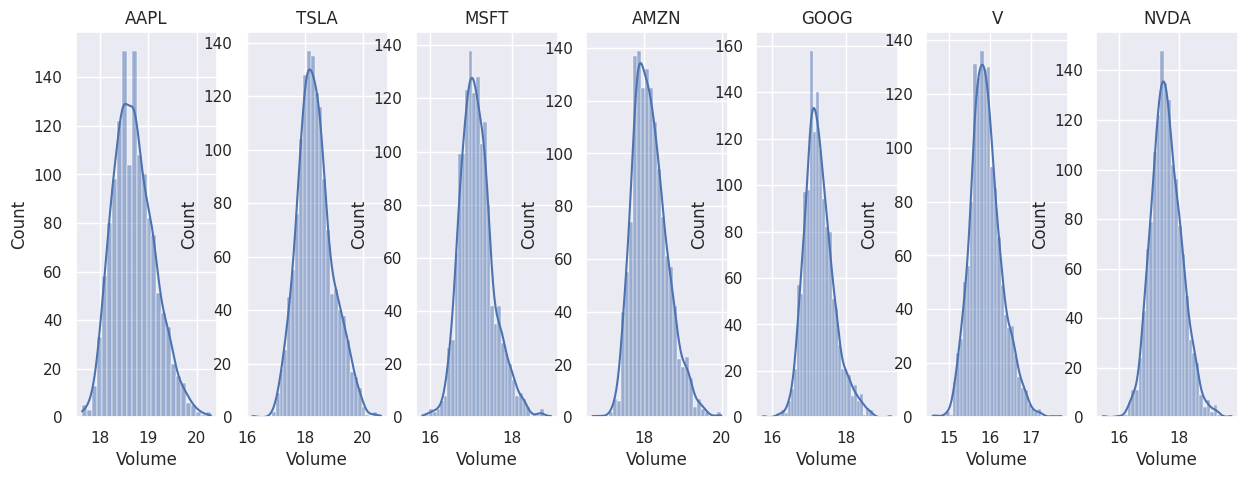

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(tickers), figsize=(15, 5))
axes = axes.flatten()
for i, t in enumerate(tickers):
    sns.histplot(np.log(dict_nasdaq[t]['Volume']), ax=axes[i], kde=True)
    axes[i].set_title(t.upper())

In [ ]:
! kaggle datasets download -d omermetinn/tweets-about-the-top-companies-from-2015-to-2020
! mkdir tweets
! unzip tweets-about-the-top-companies-from-2015-to-2020.zip -d tweets
clear_output()

In [ ]:
twts = pd.read_csv('tweets/Tweet.csv')
twts['post_date'] = pd.to_datetime(twts.post_date, unit='s')
comp_tweet = pd.read_csv('tweets/Company_Tweet.csv')
twts = twts.merge(comp_tweet, on='tweet_id', how='inner')
twts['total_engagement'] = twts['like_num'] + twts['retweet_num'] + twts['comment_num']
twts = twts[twts['total_engagement'] > 100][['writer', 'body', 'ticker_symbol', 'total_engagement', 'post_date']]
twts['post_date'] = twts.post_date.dt.ceil("d")
twts = twts.rename(columns={'post_date': 'Date', 'body': 'text'}).set_index('Date')
twts['text'] = twts.text.map(filter_out_non_text)
twts = twts.drop_duplicates(subset='text')[['writer', 'ticker_symbol', 'total_engagement', 'text']]
twts = twts.groupby([twts.index, 'ticker_symbol']).aggregate({'text': list})
twts['text'] = twts['text'].apply(lambda x: '. '.join(x))
twts = twts.reset_index(level=1)

In [ ]:
pd.read_csv('tweets/Tweet.csv').head(10)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
5,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
6,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
7,550443857142611968,Cprediction,1420071016,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
8,550443857595600896,iknowfirst_br,1420071017,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
9,550443857692078081,Gold_prediction,1420071017,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [ ]:
twts_2 = pd.read_csv('stock_market_tweets.csv').dropna()
twts_2['post_date'] = pd.to_datetime(twts_2.post_date)
twts_2['total_engagement'] = twts_2['like_num'].astype(int) + twts_2['retweet_num'].astype(int) + twts_2['comment_num'].astype(int)
twts_2 = twts_2[twts_2['total_engagement'] > 100][['writer', 'body', 'ticker_symbol', 'total_engagement', 'post_date']]
twts_2['post_date'] = twts_2.post_date.dt.ceil("d")
twts_2 = twts_2.rename(columns={'post_date': 'Date', 'body': 'text'}).set_index('Date')
twts_2['text'] = twts_2.text.map(filter_out_non_text)
twts_2 = twts_2.drop_duplicates(subset='text')[['writer', 'ticker_symbol', 'total_engagement', 'text']]

In [ ]:
news_datasets = [
                 '/content/train/raw_analyst_ratings.csv',
                 '/content/train/raw_partner_headlines.csv'
                ]
datasets = []
for fname in news_datasets:
  dataset = pd.read_csv(fname, usecols=['date', 'stock', 'headline'])
  dataset['date'] = pd.to_datetime(dataset.date.str[:10])
  dataset = dataset.rename(columns={'date': 'Date', 'headline': 'text', 'stock': 'ticker_symbol'}).set_index('Date')
  dataset['text'] = dataset.text.map(filter_out_non_text)
  datasets.append(dataset)

In [ ]:
datasets = pd.concat(datasets)

In [ ]:
datasets=datasets.drop_duplicates(subset='text')

In [ ]:
twts = pd.concat([datasets, twts[['ticker_symbol', 'text']], twts_2[['ticker_symbol', 'text']]])

In [ ]:
twts.head(10)

,text,ticker_symbol
Date,,
2020-06-05,stock that hit high on friday,A
2020-06-03,stock that hit high on wednesday,A
2020-05-26,biggest mover from friday,A
2020-05-22,stock moving in friday midday session,A
2020-05-22,b of a security maintains neutral on agilent t...,A
2020-05-22,cfra maintains hold on agilent technology lowe...,A
2020-05-22,ubs maintains neutral on agilent technology ra...,A
2020-05-22,agilent technology share are trading higher af...,A
2020-05-22,well fargo maintains overweight on agilent tec...,A


In [ ]:
twts = twts.sort_values(by='Date').drop_duplicates('text')

In [ ]:
import gc
del datasets, twts_2
gc.collect()

68

In [ ]:
def add_text(stock: str):
  tweets_about_stock = twts[twts.ticker_symbol == stock][['text']].groupby('Date').agg({'text': set})
  tweets_about_stock['text'] = tweets_about_stock['text'].map(list)
  dict_nasdaq[stock] = dict_nasdaq[stock].join(tweets_about_stock, how='left')
  dict_nasdaq[stock]['text'] = dict_nasdaq[stock]['text'].fillna('')

In [ ]:
from pandas.tseries.offsets import BDay, Day
twts.index = twts.index.map(lambda x : x - Day(1) + BDay(1))

In [ ]:
twts

,text,ticker_symbol
Date,,
1969-12-31,montpelier re holding ltd mrh new analyst repo...,MRH
2009-02-16,how treasury and etf work,NAV
2009-04-27,update on the luxury sector quarter,FT
2009-04-29,going against the herd,A
2009-05-22,charles sizemore radio interview saturday morning,AM
...,...,...
2020-06-11,morgan stanley maintains underweight on u banc...,USB
2020-06-11,cnhi brand iveco bus delivers crossway low ent...,CNHI
2020-06-11,share of several utility company are trading l...,LNT


In [ ]:
for t in tickers:
  dict_nasdaq[t].index = dict_nasdaq[t].index.tz_localize(None)

In [ ]:
tickers_mean_std = {ticker: [] for ticker in tickers}

In [ ]:
for t in tickers:
  dict_nasdaq[t]['Open'] = np.log(dict_nasdaq[t]['Open']) # звести все до лінійного тренду
  dict_nasdaq[t]['Close'] = np.log(dict_nasdaq[t]['Close'])
  dict_nasdaq[t]['Low'] = np.log(dict_nasdaq[t]['Low'])
  dict_nasdaq[t]['High'] = np.log(dict_nasdaq[t]['High'])
  dict_nasdaq[t]['Volume'] = np.log(dict_nasdaq[t]['Volume'])
  dict_nasdaq[t] = dict_nasdaq[t].fillna(method='pad')
  compute_stoch(dict_nasdaq[t])
  compute_bop(dict_nasdaq[t])
  compute_cci(dict_nasdaq[t])
  compute_mfi(dict_nasdaq[t])
  compute_wma(dict_nasdaq[t], ('Open'))
  compute_wma(dict_nasdaq[t], ('Close'))
  compute_wma(dict_nasdaq[t], ('Low'))
  compute_wma(dict_nasdaq[t], ('High'))
  for k in range(0, 15):
    compute_return_for_k_days(dict_nasdaq[t], k)
  for k in range(1, 15):
    compute_future_return_for_k_days(dict_nasdaq[t], k)
  mean = dict_nasdaq[t].mean()
  std = dict_nasdaq[t].std()
  tickers_mean_std[t].extend([mean, std])
  dict_nasdaq[t] = (dict_nasdaq[t] - mean)/std
  add_text(t)
  for text_idx in range(5):
    dict_nasdaq[t][f"text_top{text_idx + 1}"] = dict_nasdaq[t]['text'].map(lambda x: x[text_idx] if text_idx<len(x) else '')


In [ ]:
dict_nasdaq['AAPL']

,Open,Close,High,Low,Volume,slowd,slowk,BOP,CCI,MFI,...,Future_Return11_days,Future_Return12_days,Future_Return13_days,Future_Return14_days,text,text_top1,text_top2,text_top3,text_top4,text_top5
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-1.113731,-1.165114,-1.135038,-1.192141,1.103696,NaN,NaN,-1.049324,NaN,NaN,...,-0.622878,-0.480583,-0.059762,0.008171,[analyst report on top stock market option for...,analyst report on top stock market option for ...,,,,
2015-01-05,-1.192389,-1.244580,-1.205452,-1.243000,1.544533,NaN,NaN,-1.291332,NaN,NaN,...,0.011140,0.428894,0.477257,0.459613,[trading trend for from httpphilstockworldcom ...,trading trend for from httpphilstockworldcom a...,,,,
2015-01-06,-1.237793,-1.244318,-1.236812,-1.263713,1.598690,NaN,NaN,-0.299562,NaN,NaN,...,0.753901,0.790596,0.756516,0.161363,[good read from dec barronsonline by harvardwi...,good read from dec barronsonline by harvardwin...,,,,
2015-01-07,-1.220582,-1.205595,-1.216978,-1.209079,0.445149,NaN,NaN,0.575266,NaN,NaN,...,0.735694,0.704312,0.083603,0.913859,,,,,,
2015-01-08,-1.168302,-1.100750,-1.117401,-1.157289,1.358967,NaN,NaN,1.332336,NaN,NaN,...,0.422521,-0.213476,0.666661,1.097282,[those genius who traded aapl how you doing to...,those genius who traded aapl how you doing tod...,it is amazing that aapl could be up gigantic m...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,2.443930,2.398936,2.437709,2.421081,0.871374,0.979911,0.899487,-1.017916,0.743954,0.560025,...,NaN,NaN,NaN,NaN,,,,,,
2020-06-25,2.410904,2.435610,2.409021,2.413682,0.086236,0.890952,0.731396,0.928644,0.685680,0.563951,...,NaN,NaN,NaN,NaN,,,,,,
2020-06-26,2.439422,2.348826,2.411454,2.377968,1.019398,0.670679,0.330244,-1.757761,0.233876,0.067861,...,NaN,NaN,NaN,NaN,,,,,,


In [ ]:
sample = dict_nasdaq['AAPL'].sample(n=1000)

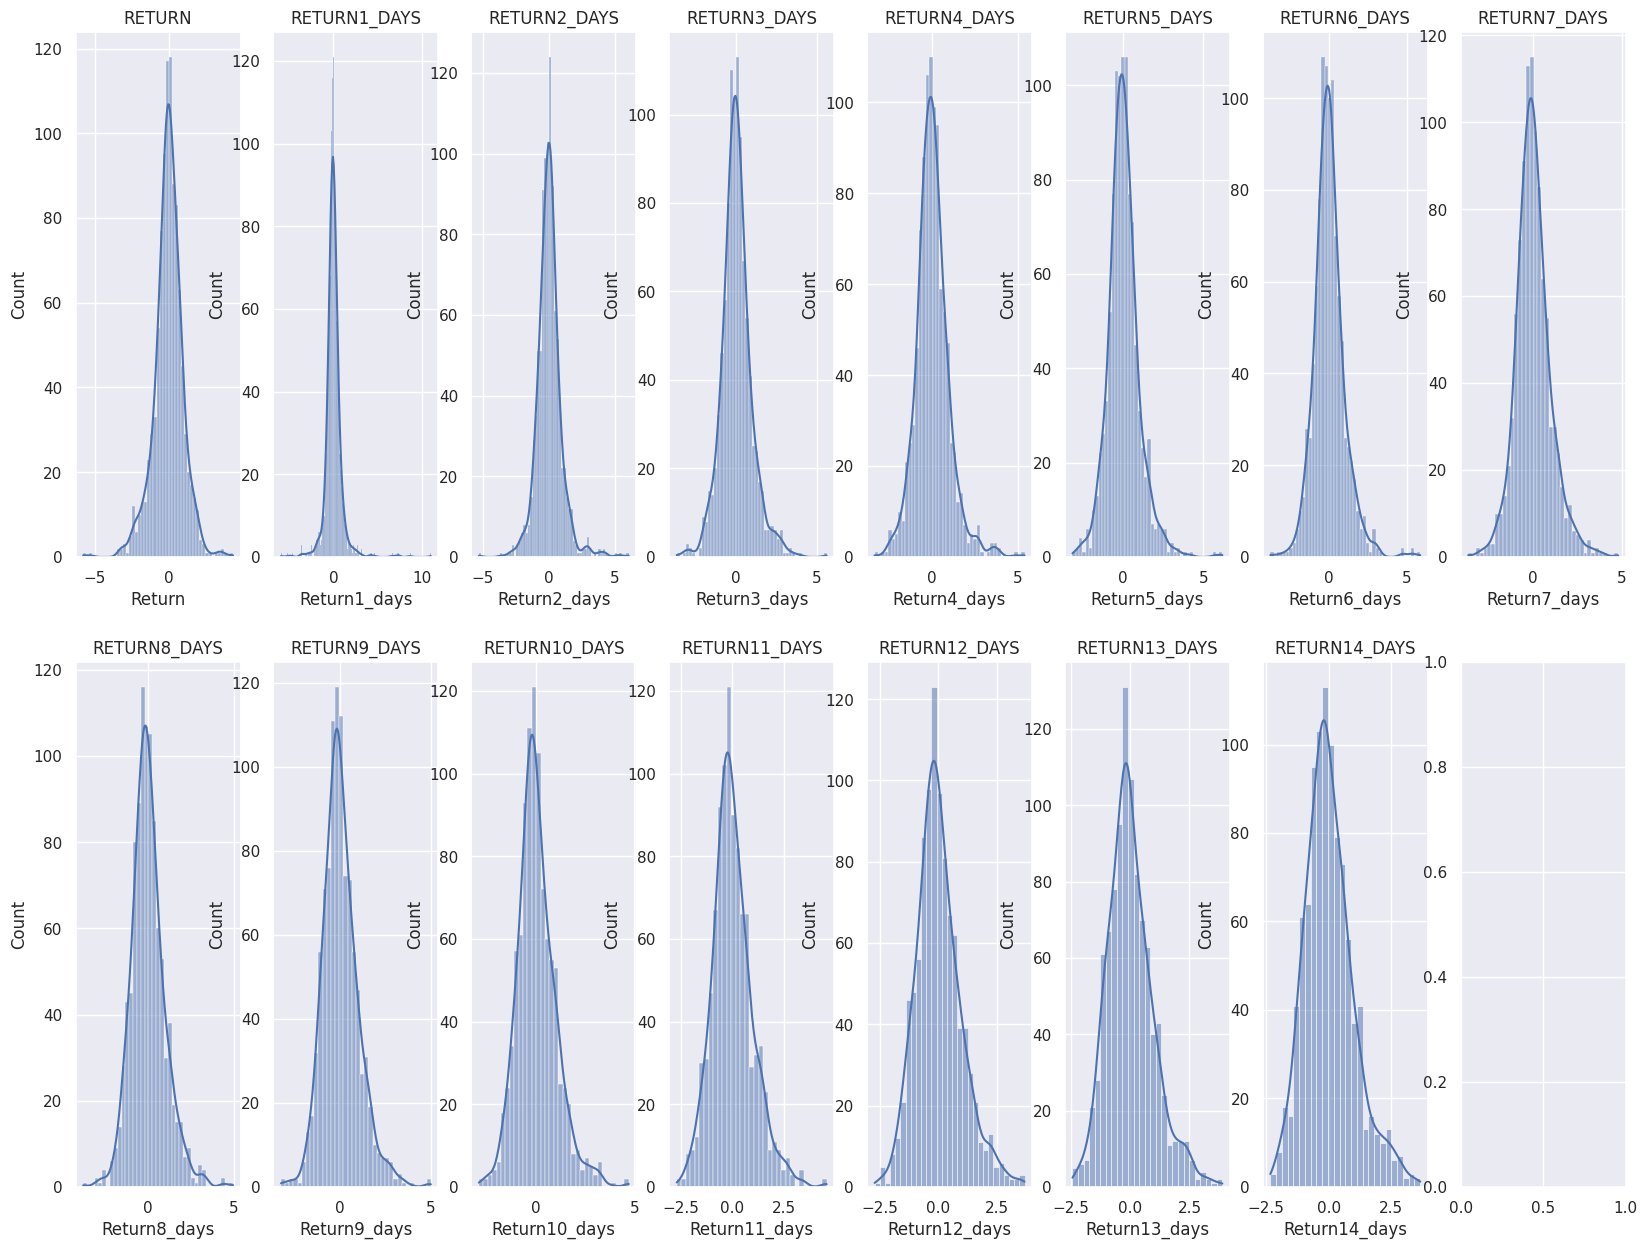

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 15))
axes = axes.flatten()
returns = ['Return' + (f'{k}_days' if k else '') for k in range(0,15)]
for i, feature in enumerate(returns):
    sns.histplot(sample[feature], ax=axes[i], kde=True)
    axes[i].set_title(feature.upper())

KeyError: ignored

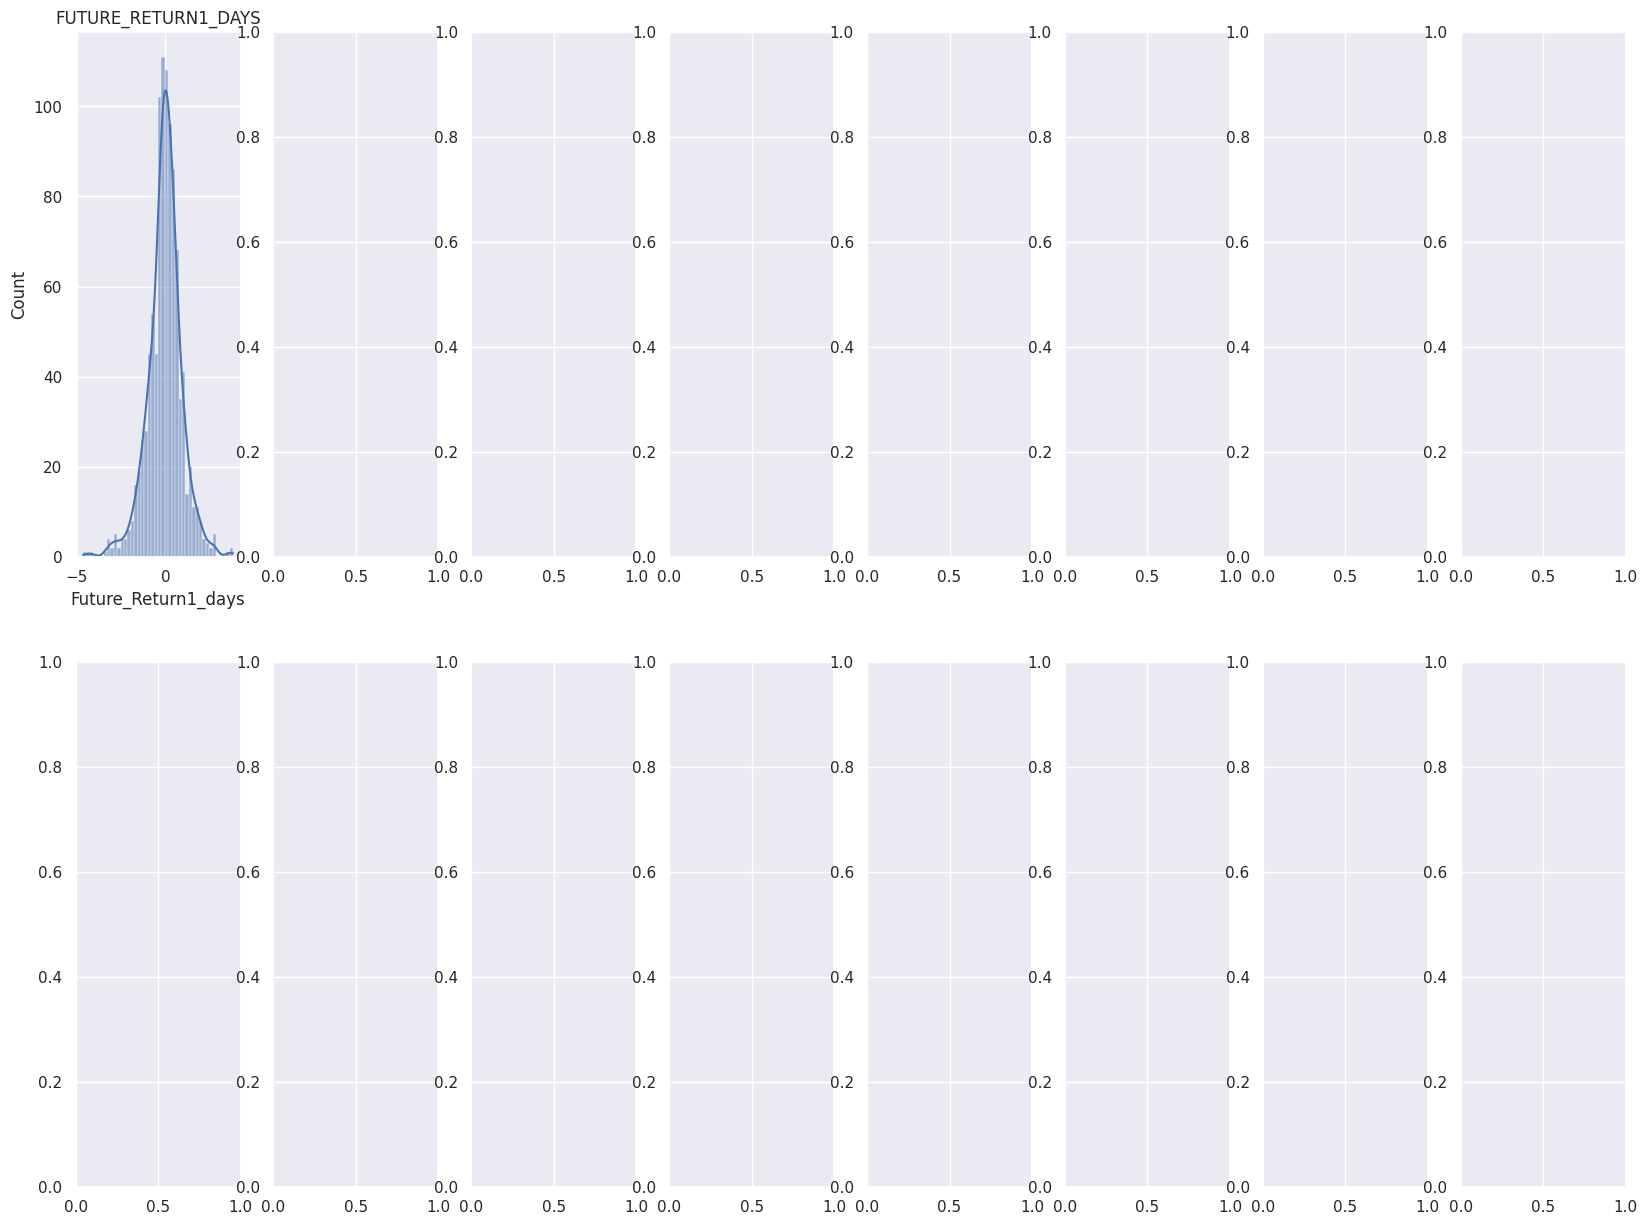

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 15))
axes = axes.flatten()
returns = ['Future_Return' + (f'{k}_days' if k else '') for k in range(1,16)]
for i, feature in enumerate(returns):
    sns.histplot(sample[feature], ax=axes[i], kde=True)
    axes[i].set_title(feature.upper())

In [ ]:
import gc
del sample
gc.collect()

84900

In [ ]:
import statsmodels.tsa.api as sm
# PACF - partial autocorrelation function (визначення кореляції між набором даних в час t і час t-k)

In [ ]:
def construct_dataset(stock: str, column_lag_order_dict: tp.Dict[str, int], columns_to_keep: tp.List[str], target_feature: str) -> tp.Dict[str, tp.List[str]]:
  new_ds = dict_nasdaq[stock][columns_to_keep].copy()
  new_ds = new_ds.rename(columns={column: f'{stock}_{column}' for column in columns_to_keep})
  column_mapping = {column: [column] for column in new_ds.columns}
  target_feature_name = f"{stock}_{target_feature}"
  new_ds[target_feature_name] = dict_nasdaq[stock][target_feature]
  for column, lag_order in column_lag_order_dict.items():
    if lag_order=='auto':
      lag_order_temp = sum(sm.stattools.pacf(dict_nasdaq[stock][column].dropna()) >= 0.1)
    else:
      lag_order_temp = lag_order
    column_mapping.update({ f"{stock}_{column}": [f"{stock}_{column}_{lag}_days" for lag in range(lag_order_temp+1)]})
    for lag in range(lag_order_temp+1):
      new_ds[f"{stock}_{column}_{lag}_days"] = dict_nasdaq[stock][column].shift(lag)
  dict_nasdaq[stock] = new_ds.dropna()
  return column_mapping, target_feature_name

In [ ]:
# TODO: перетворити pandas в tf.data.Dataset, виділити train та test (доробити для кількох ознак)
def convert_to_dataset(pandas_dataset: pd.DataFrame,
                       column_mapping: tp.Dict[tp.List[str], str],
                       target_feature_names: tp.List[str]) -> tf.data.Dataset: #ще раз запитати у Діми
  tf_datasets = []
  for subset in column_mapping.values():
    vals = pandas_dataset[subset].values
    shape = (*vals.shape, 1) # (entries, timesteps, 1)
    vals = vals.reshape(shape)
    tf_datasets.append(tf.data.Dataset.from_tensor_slices(vals))
  tf_datasets = tf.data.Dataset.zip(tuple(tf_datasets)).map(lambda *features: {feature_n: (feature if not(feature_n.split('_')[1].startswith('text')) else feature[:, 0]) for feature_n, feature in zip(column_mapping.keys(), features)})
  target_vals = pandas_dataset[target_feature_names]
  target_vals = tf.data.Dataset.from_tensor_slices(target_vals)
  tf_datasets = tf.data.Dataset.zip((tf_datasets, target_vals))
  return tf_datasets

In [ ]:
column_lag_order_dict = {
    "Open": "auto",
    "Close": "auto",
    "Low": "auto",
    "High": "auto",
    "Volume": "auto",
    "Return": "auto",
    "Return1_days": "auto",
    "Return3_days": "auto",
    "Return5_days": "auto",
    "Return14_days": "auto",
    'slowd': "auto",
    'slowk': "auto",
    'BOP': "auto",
    'CCI': "auto",
    'MFI': "auto",
    'WMA_Open': "auto",
    'WMA_Close': "auto",
    'WMA_Low': "auto",
    'WMA_High': "auto"
    }
columns_to_keep = ['Open', 'text_top1', 'text_top2', 'text_top3']
#columns_to_keep = ['Open']

target_feature = 'Future_Return7_days'

In [ ]:
features_mapping = dict()
target_variables = list()

for t in tickers:
  dict_features, targets = construct_dataset(t, column_lag_order_dict, columns_to_keep, target_feature)
  features_mapping.update(dict_features)
  target_variables.extend([targets])

In [ ]:
target_dataset = pd.concat(list(dict_nasdaq.values()), axis=1).fillna(method='pad').dropna()

In [ ]:
target_dataset

,AAPL_Open,AAPL_text_top1,AAPL_text_top2,AAPL_text_top3,AAPL_Future_Return1_days,AAPL_Open_0_days,AAPL_Open_1_days,AAPL_Open_2_days,AAPL_Close_0_days,AAPL_Close_1_days,...,NVDA_WMA_Open_2_days,NVDA_WMA_Close_0_days,NVDA_WMA_Close_1_days,NVDA_WMA_Close_2_days,NVDA_WMA_Low_0_days,NVDA_WMA_Low_1_days,NVDA_WMA_Low_2_days,NVDA_WMA_High_0_days,NVDA_WMA_High_1_days,NVDA_WMA_High_2_days
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-24,-0.609876,pmarca today value of bay area co aapl goog fb...,apple will spend billion to build it first dat...,,-1.573839,-0.609876,-0.671770,-0.701941,-0.626584,-0.609175,...,-1.802719,-1.790252,-1.796370,-1.801991,-1.790076,-1.796018,-1.802290,-1.792997,-1.798395,-1.803847
2015-02-25,-0.638956,apple is a stock jump from becoming the first ...,,,-0.486646,-0.638956,-0.609876,-0.671770,-0.698623,-0.626584,...,-1.796376,-1.784958,-1.790252,-1.796370,-1.784146,-1.790076,-1.796018,-1.787825,-1.792997,-1.798395
2015-02-26,-0.698259,,,,-0.196671,-0.698259,-0.638956,-0.609876,-0.663649,-0.698623,...,-1.790645,-1.779759,-1.784958,-1.790252,-1.778582,-1.784146,-1.790076,-1.782892,-1.787825,-1.792997
2015-02-27,-0.672199,japan raid pension fund to goose market ewj aa...,,,-0.407359,-0.672199,-0.698259,-0.638956,-0.705758,-0.663649,...,-1.784982,-1.775312,-1.779759,-1.784958,-1.773445,-1.778582,-1.784146,-1.778649,-1.782892,-1.787825
2015-03-02,-0.688324,,,,-0.035257,-0.688324,-0.672199,-0.698259,-0.692154,-0.705758,...,-1.779774,-1.769409,-1.775312,-1.779759,-1.768648,-1.773445,-1.778582,-1.773004,-1.778649,-1.782892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-04,2.115223,,,,0.948871,2.115223,2.117541,2.083774,2.091025,2.115077,...,1.302990,1.319663,1.313144,1.306005,1.316944,1.309703,1.301678,1.318927,1.312187,1.305576
2020-06-05,2.106273,,,,1.379115,2.106273,2.115223,2.117541,2.169118,2.091025,...,1.310666,1.326937,1.319663,1.313144,1.323883,1.316944,1.309703,1.325576,1.318927,1.312187
2020-06-08,2.165116,,,,1.850400,2.165116,2.106273,2.115223,2.185512,2.169118,...,1.317076,1.332739,1.326937,1.319663,1.330141,1.323883,1.316944,1.330881,1.325576,1.318927


In [ ]:
tf_ds = convert_to_dataset(target_dataset, features_mapping, target_variables)
n_records = target_dataset.shape[0]
train_fraction = 0.7
batch_size = 32
n_train = int(train_fraction * n_records)
train_ds = tf_ds.take(n_train).batch(batch_size).cache().prefetch(2048)
test_ds = tf_ds.skip(n_train).batch(batch_size).cache().prefetch(2048)

# 3. Time series model

In [ ]:
class TimeSeriesPredictor(tf.keras.Model):
  def __init__(self, feature_list: tp.List[str], num_reccurrent_dims: int, output_size: int, text_model: tf.keras.Model = None):
    super().__init__()
    self.rnn_layers = defaultdict(tf.keras.layers.Layer) # у відповідність кожній нейронці свій часовий ряд, defaultdict values фіксується
    self.feature_list = feature_list
    # encoder (LSTM від кожної з ознак)
    self.text_model=False
    for feature in self.feature_list:
      if feature.split('_')[1] =='text':
        if text_model:
          self.text_model=True
          text_model_ = text_model
          text_model_.trainable = False
          self.rnn_layers[feature] = text_model_
      else:
        self.rnn_layers[feature] = tf.keras.Sequential(
            [
              tf.keras.layers.LSTM(num_reccurrent_dims) #return_sequences повертає усі значення ряду
            ] # [1, 2, 3, 4]
          # LSTM_1 => 1->2->3->4--> output_1
          # LSTM_2 => 4 ->3->2->--> output_2
          # output = output_2 (+) output_1 (+) - або сума, або середнє або конкатенація
      )
    # decoder (Dense шари по кожній ознаці + Dense розміром з визідну характеристику)
    # f(Y*, Y) = f(X*W, Y) = (Y-X*W)^2 + lambda*sum(|W|), lambda - коеф регуляризації (L1) (LASSO regression)
    # f(Y*, Y) = f(X*W, Y) = (Y-X*W)^2 + lambda*sum(W^2), lambda - коеф регуляризації (L2) (Ridge)
    # f(Y*, Y) = f(X*W, Y) = (Y-X*W)^2 + lambda*sum(W^2) + kappa*sum(|W|), регуляризації (L2+L1) (Elastic Net)
    # |W| -> median (непотрібні фічі можна видалити) |W|
    # W^2 -> mean (просто згладжує, намагається триати ваги якогомога меншими за значенням)
    self.dense_output = tf.keras.layers.Dense(output_size)

  def call(self, x: tf.Tensor):
    rnn_outputs = []
    for feature in self.feature_list:
      if feature.split('_')[1] == 'text':
        if self.text_model:
          rnn_outputs.append(self.rnn_layers[feature](x[feature]))
      else:
        rnn_outputs.append(self.rnn_layers[feature](x[feature])) # х - вхідний часовий ряд
    rnn_outputs = tf.concat(rnn_outputs, axis=-1) # скласти по колонкам
    out = self.dense_output(rnn_outputs)
    return out

In [ ]:
model_wo_text = TimeSeriesPredictor(feature_list=features_mapping.keys(), num_reccurrent_dims=64, output_size=len(target_variables))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5, verbose=1, mode='min', min_delta=1e-4)
model_wo_text.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model_wo_text.fit(train_ds, validation_data=test_ds, epochs=100, verbose=1, callbacks=[callback])
#models_w_text[t].save(f'{t}_with_text')

Epoch 1/100
30/30 [==============================] - 224s 1s/step - loss: 0.7131 - root_mean_squared_error: 0.8445 - mean_absolute_error: 0.6294 - val_loss: 1.2486 - val_root_mean_squared_error: 1.1174 - val_mean_absolute_error: 0.8597
Epoch 2/100
30/30 [==============================] - 2s 66ms/step - loss: 0.5820 - root_mean_squared_error: 0.7629 - mean_absolute_error: 0.5789 - val_loss: 0.8627 - val_root_mean_squared_error: 0.9288 - val_mean_absolute_error: 0.6742
Epoch 3/100
30/30 [==============================] - 2s 80ms/step - loss: 0.4309 - root_mean_squared_error: 0.6564 - mean_absolute_error: 0.4998 - val_loss: 0.8464 - val_root_mean_squared_error: 0.9200 - val_mean_absolute_error: 0.6931
Epoch 4/100
30/30 [==============================] - 2s 68ms/step - loss: 0.3916 - root_mean_squared_error: 0.6258 - mean_absolute_error: 0.4768 - val_loss: 0.7458 - val_root_mean_squared_error: 0.8636 - val_mean_absolute_error: 0.6441
Epoch 5/100
30/30 [==============================] - 2s 

In [ ]:
model_w_text = TimeSeriesPredictor(feature_list=features_mapping.keys(), num_reccurrent_dims=64, output_size=len(target_variables), text_model=semantic_model)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5, verbose=1, mode='min', min_delta=1e-4)
model_w_text.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model_w_text.fit(train_ds, validation_data=test_ds, epochs=100, verbose=1, callbacks=[callback])
#models_w_text[t].save(f'{t}_with_text')

Epoch 1/100
30/30 [==============================] - 235s 2s/step - loss: 0.6878 - root_mean_squared_error: 0.8294 - mean_absolute_error: 0.6097 - val_loss: 1.0335 - val_root_mean_squared_error: 1.0166 - val_mean_absolute_error: 0.7474
Epoch 2/100
30/30 [==============================] - 3s 99ms/step - loss: 0.5180 - root_mean_squared_error: 0.7197 - mean_absolute_error: 0.5353 - val_loss: 0.7508 - val_root_mean_squared_error: 0.8665 - val_mean_absolute_error: 0.6229
Epoch 3/100
30/30 [==============================] - 3s 88ms/step - loss: 0.4107 - root_mean_squared_error: 0.6408 - mean_absolute_error: 0.4790 - val_loss: 0.6610 - val_root_mean_squared_error: 0.8130 - val_mean_absolute_error: 0.5865
Epoch 4/100
30/30 [==============================] - 3s 87ms/step - loss: 0.3643 - root_mean_squared_error: 0.6036 - mean_absolute_error: 0.4519 - val_loss: 0.6372 - val_root_mean_squared_error: 0.7982 - val_mean_absolute_error: 0.5829
Epoch 5/100
30/30 [==============================] - 3s 

In [ ]:
import gc
gc.collect()

23

In [ ]:
tickers_mean_std['AAPL'][0]['Future_Return14_days']

0.013643170309639914

In [ ]:
predictions=[]
predictions_true=[]
for x, y in tqdm(test_ds):
  predictions.append(model_w_text.predict(x, verbose=0))
  predictions_true.append(y.numpy())
predictions = pd.DataFrame(np.vstack(predictions), columns=[col+'_pred' for col in tickers])
predictions_true = pd.DataFrame(np.vstack(predictions_true), columns=tickers)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
predictions

,AAPL_pred,TSLA_pred,MSFT_pred,AMZN_pred,GOOG_pred,V_pred,NVDA_pred
0,-2.106994,-0.231226,-0.490658,-1.514440,-0.496108,-0.928451,-3.620057
1,-2.175189,-0.240960,-0.566334,-1.177161,-0.380036,-0.535173,-3.541471
2,-3.001967,-0.138697,-0.922924,-1.592020,-0.754839,-0.899824,-4.076220
3,-3.187914,-0.116999,-1.223317,-1.824983,-0.434589,-1.117687,-4.036057
4,-2.499519,-0.271455,-0.844864,-1.111196,-0.166340,-0.982332,-2.852208
...,...,...,...,...,...,...,...
396,1.365473,1.354622,1.327401,0.695652,0.700989,0.855346,0.060318
397,1.551003,1.499638,1.617737,1.004241,1.027996,1.111683,0.145487
398,1.402433,1.072433,1.062923,0.472212,0.478627,0.491584,0.100429
399,1.093673,1.063741,0.535910,-0.078463,0.021639,0.344377,-0.164140


In [ ]:
predictions_true

,AAPL,TSLA,MSFT,AMZN,GOOG,V,NVDA
0,-2.576381,-0.004873,-0.218853,-1.027339,-0.314181,-0.836376,-3.641518
1,-2.429334,-0.018877,-0.281672,-0.672929,-0.115505,-0.841245,-3.461054
2,-2.153822,-0.027296,0.063769,-0.290219,0.091642,-0.367609,-3.168277
3,-2.623612,-0.291541,-0.524228,-1.033590,-0.254570,-1.074349,-3.217938
4,-2.378429,-0.095546,-0.230296,-0.697327,0.144334,-0.602773,-2.413104
...,...,...,...,...,...,...,...
396,1.397822,0.461934,1.079002,1.125135,-0.182382,-0.778739,0.251840
397,1.650615,0.765205,1.508331,1.431225,0.160487,-0.509049,0.445682
398,0.844082,0.205452,0.752364,0.764065,-1.028602,-1.428844,-0.002505
399,1.107342,0.419179,0.745876,0.523739,-0.855517,-1.048700,0.132468


In [ ]:
predictions_ = pd.concat([predictions, predictions_true], axis=1)

In [ ]:
import gc
gc.collect()

66712

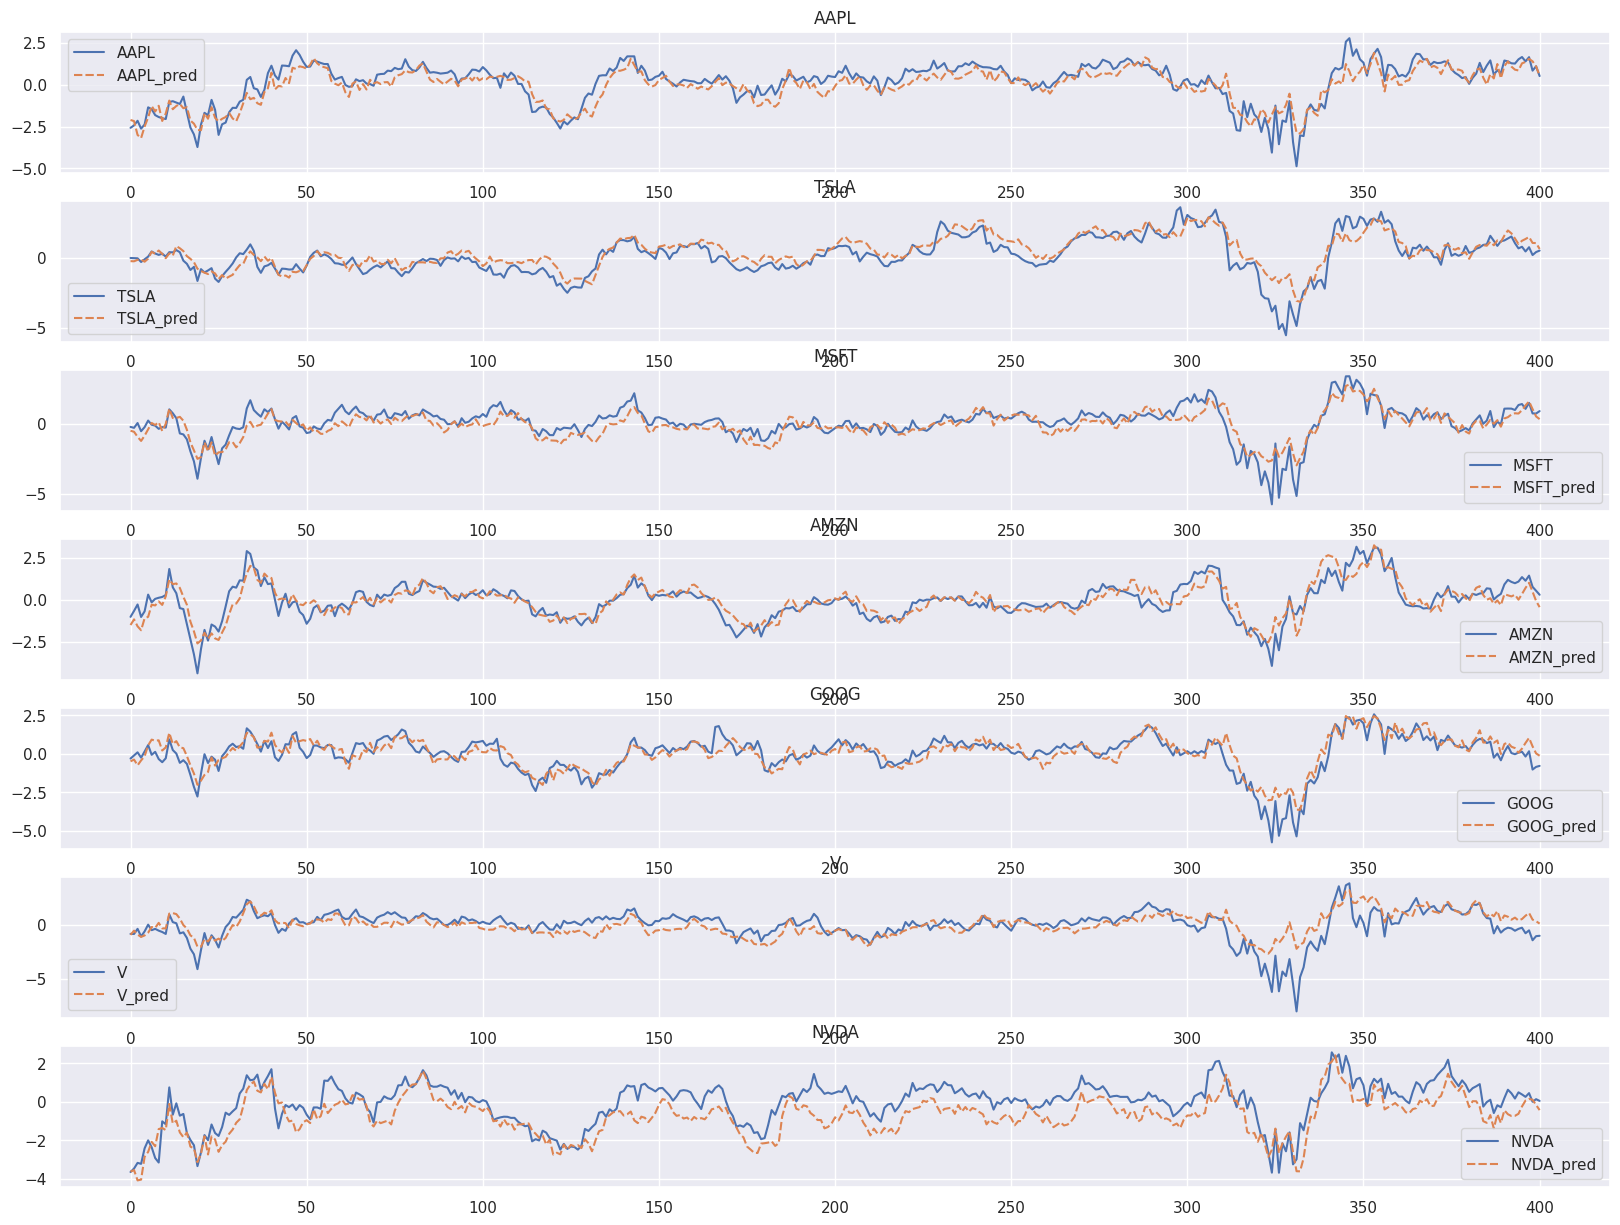

In [ ]:
fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(20, 15))
axes = axes.flatten()
for i, stock in enumerate(tickers):
    sns.lineplot(predictions_[[stock, stock+'_pred']], ax=axes[i])
    axes[i].set_title(stock.upper())

<Axes: >

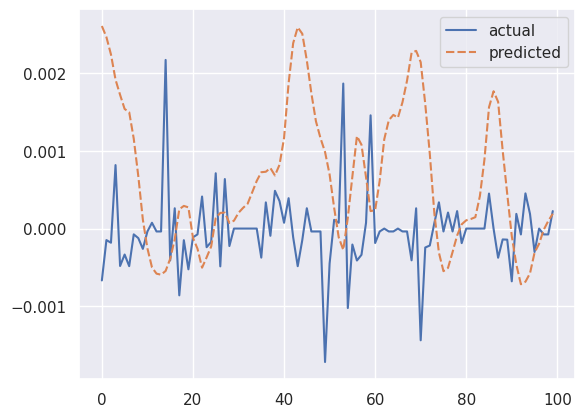

In [ ]:
predictions_vs_true = pd.DataFrame({'actual': predictions_true[:100], 'predicted': predictions[:100]})
sns.lineplot(data=predictions_vs_true)

# 4. Portfolio Optimization

In [ ]:
predictions = []
for x, _ in tqdm(test_ds):
  predictions.append(model_w_text.predict(x, verbose=0))
predicted_return = np.vstack(predictions)
portfolio = predicted_return

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
portfolio = predictions.rename(columns={col+'_pred':col for col in tickers})

In [ ]:
for t in tickers:
  portfolio[t] = (portfolio[t]*tickers_mean_std[t][1]['Future_Return14_days'])+tickers_mean_std[t][0]['Future_Return14_days']

In [ ]:
portfolio.shape

(401, 7)

In [ ]:
portfolio

,AAPL,TSLA,MSFT,AMZN,GOOG,V,NVDA
0,-0.123044,-0.013413,-0.008497,-0.080076,-0.015953,-0.030376,-0.334863
1,-0.127468,-0.014679,-0.012325,-0.057233,-0.009645,-0.012563,-0.326919
2,-0.181103,-0.001380,-0.030360,-0.085330,-0.030014,-0.029079,-0.380973
3,-0.193166,0.001442,-0.045554,-0.101107,-0.012610,-0.038947,-0.376913
4,-0.148508,-0.018645,-0.026412,-0.052766,0.001969,-0.032816,-0.257247
...,...,...,...,...,...,...,...
396,0.102225,0.192825,0.083457,0.069603,0.049105,0.050419,0.037159
397,0.114261,0.211684,0.098142,0.090503,0.066877,0.062030,0.045768
398,0.104623,0.156127,0.070081,0.054471,0.037021,0.033943,0.041213
399,0.084593,0.154996,0.043425,0.017176,0.012185,0.027275,0.014470


In [ ]:
! pip install --quiet PyPortfolioOpt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [ ]:
mu = mean_historical_return(portfolio, returns_data=True, frequency=256, compounding=False)
S = CovarianceShrinkage(portfolio, returns_data=True, frequency=256).ledoit_wolf()

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))


{'AAPL': 0.0, 'TSLA': 0.89822, 'MSFT': 0.0, 'AMZN': 0.0, 'GOOG': 0.0, 'V': 0.10178, 'NVDA': 0.0}


In [ ]:
portfolio_actual = read_tickers(tickers)

In [ ]:
for t in tickers:
  portfolio_actual[t] = np.log(portfolio_actual[t])
  compute_return_for_k_days(portfolio_actual[t], 0)
  portfolio_actual[t] = portfolio_actual[t][['Return']].rename(columns={'Return':t})

In [ ]:
returns = []
for t in tickers:
  returns.append(portfolio_actual[t])
portfolio_actual = pd.concat(returns, axis=1)

In [ ]:
portfolio_actual = portfolio_actual.dropna()

In [ ]:
n_records = portfolio_actual[t].shape[0]
train_fraction = 0.7
train_samples = int(train_fraction * n_records)
portfolio_actual_test = portfolio_actual.iloc[train_samples:].fillna(0)

In [ ]:
portfolio_actual_test

,AAPL,TSLA,MSFT,AMZN,GOOG,V,NVDA
Date,,,,,,,
2018-11-05 00:00:00-05:00,-0.013354,0.002640,0.010660,-0.018123,-0.014233,0.000000,-0.012296
2018-11-06 00:00:00-05:00,0.009120,0.005852,0.003161,0.015001,0.015588,0.007057,-0.001846
2018-11-07 00:00:00-05:00,0.019139,0.013941,0.022765,0.048130,0.022559,0.016997,0.000187
2018-11-08 00:00:00-05:00,-0.007121,0.008287,-0.000447,-0.000051,-0.008262,0.004347,-0.025924
2018-11-09 00:00:00-05:00,-0.005268,0.004317,-0.011614,-0.011652,-0.007327,-0.001874,0.016027
...,...,...,...,...,...,...,...
2020-06-24 00:00:00-04:00,-0.013627,-0.034030,-0.018827,-0.016539,-0.020419,-0.028888,-0.025734
2020-06-25 00:00:00-04:00,0.011412,0.032689,0.012759,0.005471,0.007962,0.014958,0.014247
2020-06-26 00:00:00-04:00,-0.030028,-0.035859,-0.017170,-0.030065,-0.051235,-0.020034,-0.036992


In [ ]:
mu = mean_historical_return(portfolio_actual_test, returns_data=True, frequency=256, compounding=False)
S = CovarianceShrinkage(portfolio_actual_test, returns_data=True, frequency=256).ledoit_wolf()

from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights_ = ef.set_weights(weights)

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'AAPL': 0.0, 'TSLA': 0.89822, 'MSFT': 0.0, 'AMZN': 0.0, 'GOOG': 0.0, 'V': 0.10178, 'NVDA': 0.0}


In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 31.9%
Annual volatility: 43.1%
Sharpe Ratio: 0.69


(0.31879067798484007, 0.43126241076713545, 0.6928280103367858)

In [ ]:
del portfolio
gc.collect()

84529

In [ ]:
portfolio = defaultdict(list)
for t in tickers:
  predictions = []
  for x, _ in tqdm(test_ds[t]):
    predictions.append(models_wo_text[t].predict(x, verbose=0))
  predicted_return = np.vstack(predictions).ravel()
  portfolio[t] = predicted_return

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
portfolio_lengths = min(
    map(
        lambda dict_entry: len(dict_entry),
    portfolio.values()
    )
)

In [ ]:
portfolio = pd.DataFrame({k: v[: portfolio_lengths] for k, v in portfolio.items()})

In [ ]:
mu = mean_historical_return(portfolio, returns_data=True, frequency=106305, compounding=False)
S = CovarianceShrinkage(portfolio, returns_data=True, frequency=106305).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))


{'AAPL': 0.09851, 'TSLA': 0.87516, 'MSFT': 0.01655, 'AMZN': 0.00978}


In [ ]:
returns = portfolio.pct_change().dropna()
hrp = HRPOpt(portfolio)
hrp_weights = hrp.optimize()
print(dict(hrp_weights))

ValueError: ignored

In [ ]:
mu = mean_historical_return(portfolio_actual_test, returns_data=True, frequency=7.5*252, compounding=False)
S = CovarianceShrinkage(portfolio_actual_test, returns_data=True, frequency=7.5*252).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights_ = ef.set_weights(weights)

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

In [ ]:
ef.portfolio_performance(verbose=True)

In [ ]:
hrp = HRPOpt(portfolio_actual_test)
hrp.set_weights(hrp_weights)
hrp.portfolio_performance(verbose=True)

In [ ]:
mu = mean_historical_return(portfolio_actual.iloc[:train_samples].fillna(0), returns_data=True, frequency=252, compounding=False)
S = CovarianceShrinkage(portfolio_actual.iloc[:train_samples].fillna(0), returns_data=True, frequency=252).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'AAPL': 0.0, 'TSLA': 0.0, 'MSFT': 0.53166, 'AMZN': 0.0, 'GOOG': 0.0, 'V': 0.0, 'NVDA': 0.46834}


In [ ]:
mu = mean_historical_return(portfolio_actual_test, returns_data=True, frequency=252, compounding=False)
S = CovarianceShrinkage(portfolio_actual_test, returns_data=True, frequency=252).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights_ = ef.set_weights(weights)

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'AAPL': 0.0, 'TSLA': 0.0, 'MSFT': 0.53166, 'AMZN': 0.0, 'GOOG': 0.0, 'V': 0.0, 'NVDA': 0.46834}


In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 21.0%
Annual volatility: 28.7%
Sharpe Ratio: 0.66


(0.21011860101960372, 0.28739667840379507, 0.6615198271445757)

In [ ]:
weights